In [1]:
%matplotlib inline

In [2]:
import os
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling/notebooks


In [3]:
#os.chdir('AnomaliesRecycling')
os.chdir('..')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling



Transfer Learning
==============================================
Based on this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data)


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

from src.transfer_learning import TransferLearningTrainer
from src.cam import CAM


plt.ion()   # interactive mode

In [5]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device_count()

1

Load Data and Data Augmentation
---------

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        #transforms.RandomRotation(degrees=(0, 180)),
        #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
        #transforms.RandomSolarize(threshold=0.5),
        #transforms.RandomAdjustSharpness(sharpness_factor=50, p=0.5),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
transferLearningTrainer = TransferLearningTrainer(data_transforms=data_transforms)

Visualize a few images



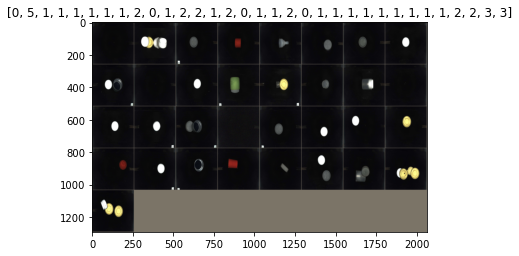

In [8]:
# Get a batch of training data
sample = next(iter(transferLearningTrainer.dataloaders['train']))
inputs, classes = sample['image'], sample['label']
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
transferLearningTrainer.imshow(out, [transferLearningTrainer.class_names[x] for x in classes])

Training the model
------------------

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [49]:
from collections import Counter
import pandas as pd

train_classes = transferLearningTrainer.image_datasets['train'].img_labels['count'].tolist()
class_count = Counter(train_classes)
weight = torch.tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values], dtype=torch.float).to(DEVICE) # 0.867868-6 

In [10]:
import numpy as np
import sklearn
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

y_train = transferLearningTrainer.image_datasets['train'].img_labels['count'].tolist()
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

#weight = 1. / np.sqrt(class_sample_count) # (*20): 0.830330-1, (): 0.846847-2, (sqrt): 0.891892-4
weight = 1. - class_sample_count / sum(class_sample_count) # 0.932432-3
#weight = sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train) # 0.843844-5

weight = torch.tensor(weight, dtype=torch.float).to(DEVICE)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, class_num=6, alpha=None, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = Variable(torch.ones(class_num, 1))
        else:
            if isinstance(alpha, Variable):
                self.alpha = alpha
            else:
                self.alpha = Variable(alpha)
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average

    def forward(self, inputs, targets):
        N = inputs.size(0)
        C = inputs.size(1)
        P = F.softmax(inputs)

        class_mask = inputs.data.new(N, C).fill_(0)
        class_mask = Variable(class_mask)
        ids = targets.view(-1, 1)
        class_mask.scatter_(1, ids.data, 1.)
        #print(class_mask)


        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()
        alpha = self.alpha[ids.data.view(-1)]

        probs = (P*class_mask).sum(1).view(-1,1)

        log_p = probs.log()
        #print('probs size= {}'.format(probs.size()))
        #print(probs)

        batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p 
        #print('-----bacth_loss------')
        #print(batch_loss)


        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        return loss

In [11]:
model_name = "test"
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
criterion = nn.CrossEntropyLoss(weight=weight)
#criterion = FocalLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

 ***Train and evaluate***

In [12]:
model_ft = transferLearningTrainer.train_model(model=model_ft,
                                               criterion=criterion,
                                               optimizer=optimizer_ft,
                                               scheduler=exp_lr_scheduler,
                                               num_epochs=2,
                                               model_name=model_name,
                                               early_stop=False)

Epoch 0/1
----------
train Loss: 0.6184 Acc: 0.8218 MAE: 0.2030 MSE: 0.2620 R^2: 0.6411
test Loss: 0.6455 Acc: 0.6411 MAE: 0.3604 MSE: 0.3634 R^2: 0.4958

Epoch 1/1
----------
train Loss: 0.2932 Acc: 0.9267 MAE: 0.0759 MSE: 0.0812 R^2: 0.8888
test Loss: 0.7892 Acc: 0.4625 MAE: 0.5375 MSE: 0.5375 R^2: 0.2541

Training complete in 0m 48s
Best test acc: 0.641141
Best test mae: 0.360360
Best test mse: 0.363363
Best test R^2: 0.495791


/cvhci/temp/p22g5/data/presorted/trial (1118).jpg


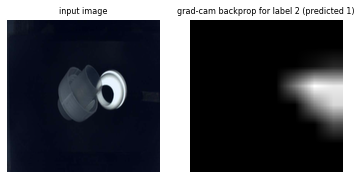

In [13]:
model_name += "_weights.pth"
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 6, since we have 6 classes
model_ft.fc = torch.nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
model_ft.load_state_dict(torch.load(transferLearningTrainer.MODELS_DIR + model_name))
# print(model_ft)

cam = CAM(transferLearningTrainer)
cam.print_cam(model_ft)

In [ ]:
!reload_ext tensorboard
!tensorboard --logdir /cvhci/temp/p22g5/runs/

***Filenames where validation failed***

In [11]:
_ = transferLearningTrainer.print_misclassified(model_ft, plot=True)

cluttered/Anlerndaten (830).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (460).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (154).jpg
must be 5, but predicted 4
harder_samples/Anlernbilder (338).jpg
must be 3, but predicted 2
cluttered/Anlerndaten (875).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (161).jpg
must be 2, but predicted 1
harder_samples/Anlernbilder (171).jpg
must be 3, but predicted 2
presorted/trial (127).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (764).jpg
must be 1, but predicted 0
cluttered/Anlerndaten (615).jpg
must be 2, but predicted 1
cluttered/Anlerndaten (465).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (193).jpg
must be 3, but predicted 2
harder_samples/Anlernbilder (149).jpg
must be 3, but predicted 2
presorted/trial (1326).jpg
must be 2, but predicted 1
harder_samples/Anlernbilder (362).jpg
must be 4, but predicted 2
harder_samples/Anlernbilder (88).jpg
must be 3, but predicted 2
harder_samples/Anlernbilde

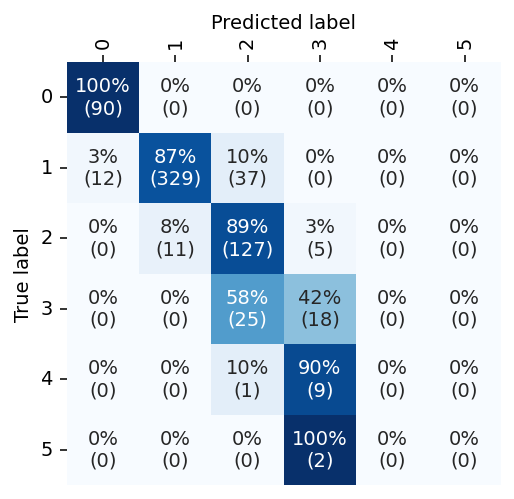

In [14]:
transferLearningTrainer.print_confusion_matrix(model_ft)

ConvNet as fixed feature extractor
----------------------------------

In [ ]:
model_name = "ResNet18_test"
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(transferLearningTrainer.class_names))
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = transferLearningTrainer.train_model(model_conv,
                                                 criterion,
                                                 optimizer_conv,
                                                 exp_lr_scheduler,
                                                 num_epochs=50,
                                                 model_name=model_name)

In [ ]:
transferLearningTrainer.visualize_model(model_conv)